Roadmap:
- Learn which data structure of y will have the best statistical control and thus prediction confidence will be high.
(Ex. financial markets data always changes stdev, trend, noise and etc.)
- Raw price data won't work. Proceeding with log(pct_change())
- Create simulator function of strategy returns with particular conditions (after sucessful testing with financial data).

Observations:
- Verified that first producing IMFs on already all the data and splitting to train/test does not affect the IMFs. (Ex. producing imfs only on train slice will be identical to the IMFs produced on the whole dataset, this nothing is leaking and will work in the future!)

Start with daily closing price. Continue with detrended TS of daily pct returns or boolean classification signals based on expected pct return condition(ex. above std return enter).

## VMD-LSTM-NN Regression v1.0 (Financial data)

To do:
- Create standart procedure for VMD parameter optimization - done
- Verify that complex model performs better than simple model without special pre-processing
- Try other datasets (make sure to follow statistical control of the data)

Notes:
- Do we need to have normally distributed residuals in reconstructed error (sum(IMFs) - y) - not really
- Create param.py that will contain train/test split and generator length train/test slices

batch size in tf.generator is 128 make sure it is okay like that

In [1]:
from vmdpy import VMD
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Conv1D, Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
# need to create validation part of testing!

class vmd_lstm:

    def train_data(x_train, y_train, length=21):
        '''Train data generator. Can be many steps ahead forecast.
        '''
        data_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_train,
            y_train,
            length=length,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=128
        )  # missing target length horizon (only manual setting)
        return data_gen
    
    def test_data(x_test, length=21):
        '''Test data should not leak target,
        y_test == np.zeros(len(x_test)).
        '''
        data_gen_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_test,
            np.zeros(len(x_test)),
            length=length,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=128
        )  # missing target length horizon (only manual setting)
        return data_gen_test
    
    def lstm(input_data, epochs=500, learning_rate=1e-3):
        '''Custom model LSTM-DNN.
        Returns keras.models.Sequential()
        formula and prints log(loss) plot for reference.
        '''
        model = keras.models.Sequential()
        # model.add(keras.layers.Input(shape=(21, 13)))
        # Can have CNN layer if we have many IMFs (test)
        model.add(LSTM(128, return_sequences=True, activation='relu'))
        model.add(LSTM(64, return_sequences=False, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss=['mse'])
        a = model.fit(input_data, shuffle=False, epochs=epochs, workers=-1, use_multiprocessing=True)
        plt.figure(figsize=(14,8))
        plt.plot(np.log1p(a.history['loss']))
        plt.title("log(Loss history)")
        plt.grid()

        return model
    
    def vmd(input_data, n_modes=13, alpha=200, tol=1e-20, plot=True):
        '''Input data and decompose it to n-modes.
        Function to be used in sensitivity analysis in pre-processing part.
        Returns decomposed_data , y_hat, omega.
        Use plot=False when grid searching for parameters.
        '''
        # Params  
        alpha = alpha  # quadratic penalty, high alpha == bias (sensitivity analysis)
        tau = 0.  # noise-tolerance (no strict fidelity enforcement)  
        K = n_modes  # modes count (sensitivity analysis)
        DC = 0  # no DC part imposed  
        init = 1  # initialize omegas uniformly  
        tol = tol  

        # VMD 
        modes, u_hat, omega = VMD(input_data, alpha, tau, K, DC, init, tol)  

        # Reconstruct data
        y = input_data
        reconstruct = np.sum(pd.DataFrame(modes))  # additive components; shape==(503, 13)
        rmse = np.sqrt(1/len(y) * np.sum(np.square(y-reconstruct)))
        mape = np.mean(np.abs(reconstruct/y-1))
    
        if plot == True:
            # Visualize decomposed modes
            plt.figure(figsize=(14,8))
            plt.subplot(2,1,1)
            plt.plot(input_data)
            plt.title('Original signal')
            plt.subplot(2,1,2)
            plt.plot(modes.T)
            plt.title('Decomposed modes')
            plt.legend(['Mode %d'%m_i for m_i in range(modes.shape[0])])
            plt.tight_layout()

            plt.figure(figsize=(14,8))
            plt.plot(y-reconstruct)
            plt.title("Reconstruction error")
            plt.figure(figsize=(14,8))
            plt.hist(y-reconstruct, bins='fd')

        return modes.T, rmse, mape
    
    def predict_test(x_test, len=21):
        '''x_test = Test data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 100 - len
        y_act = pd.Series(y[-offset_length:])  # uses global y
        y_pred = model.predict(x_test)  # weird format
        y_pred = pd.Series(y_pred.T[0])
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()

        return y_pred, y_act

    def predict_train(x_train, len=21):
        '''x_train = Train data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 100 - len
        y_act = pd.Series(y[:-100]).shift(-21)
        y_pred = model.predict(x_train)
        y_pred = pd.Series(y_pred.T[0])
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()
        
        return y_pred, y_act


Data import and transform

In [72]:
import yfinance as yf

spy_df = yf.download(tickers = "SPY",  # list of tickers
                period = "5y",         # time period
                interval = "1d",       # trading interval
                prepost = False,       # download pre/post market hours data?
                repair = True)

[*********************100%***********************]  1 of 1 completed


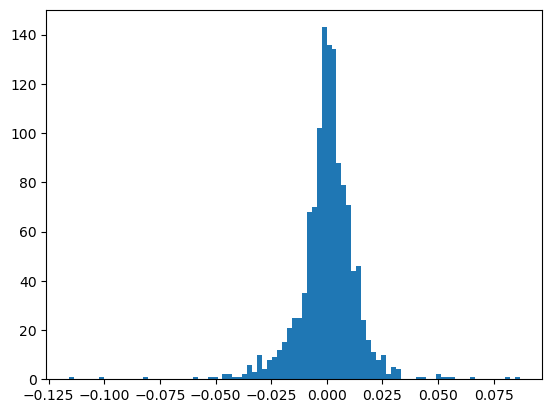

In [112]:
spy_pct = np.log1p(spy_df["Adj Close"].pct_change().dropna())
spy_pct = np.array(spy_pct)
plt.hist(spy_pct, bins='fd')
# Note: Reverse log transform with np.expm1()
plt.show()

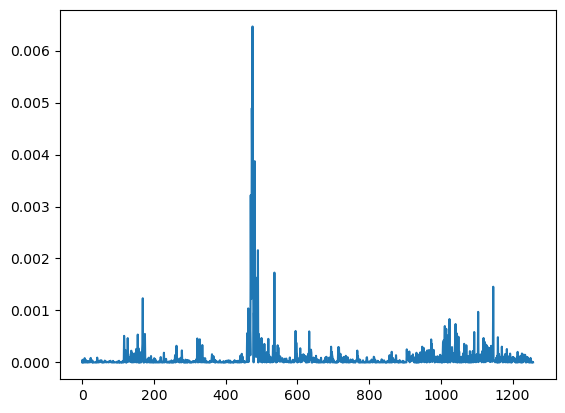

In [113]:
plt.plot(np.expm1(spy_pct) - spy_pct)

In [180]:
%%time
# Gridsearch vmd parameters
# Sensitivity analysis
alphas = list(range(100, 1000, 50))  #range(start,_,_) is really important condition
Ks = list(range(2, 30, 1))  #list(range(2, 50, 1))
y = spy_pct
print('All combinations:', len(alphas) * len(Ks))

result_collect = []
for i in alphas:
    for j in Ks:
        modes, rmse, mape = vmd_lstm.vmd(y, n_modes=j, alpha=i, plot=False)
        result_collect.append([i, j, rmse])

All combinations: 504
CPU times: total: 11min 57s
Wall time: 12min 59s


In [181]:
result = pd.DataFrame(result_collect, columns=['alpha', 'K', 'rmse'])

In [173]:
result.nsmallest(5, "rmse")

,alpha,K,rmse
27,50,29,0.000156
24,50,26,0.000157
25,50,27,0.000157
23,50,25,0.000157
22,50,24,0.000157


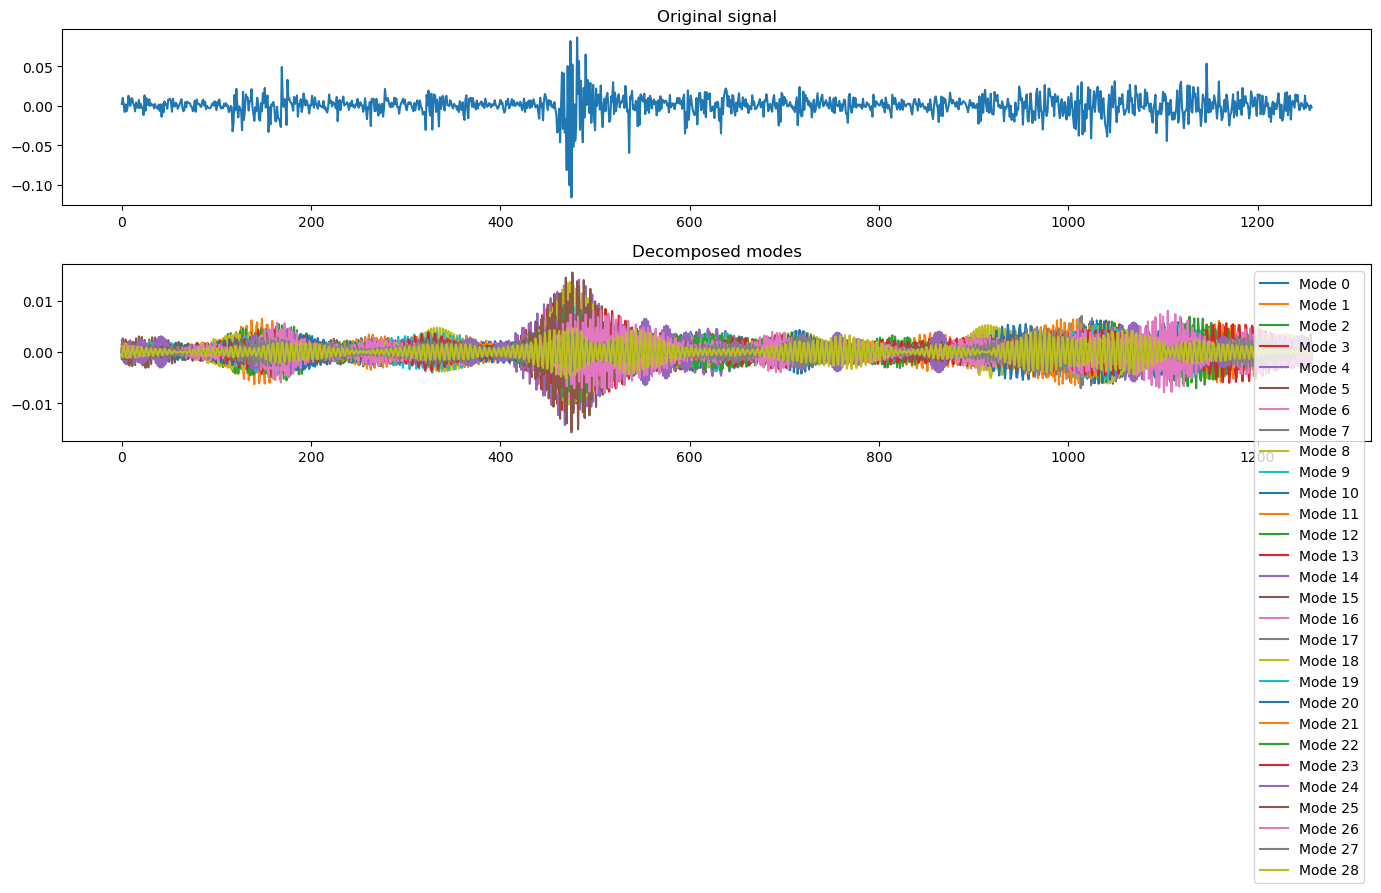

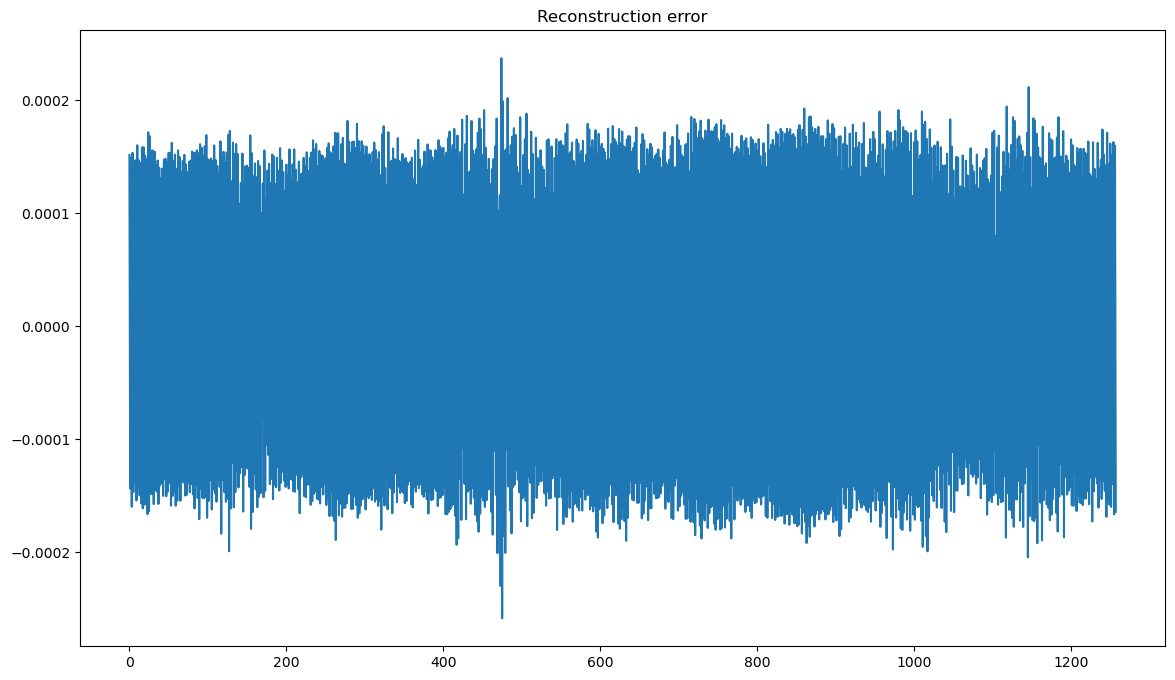

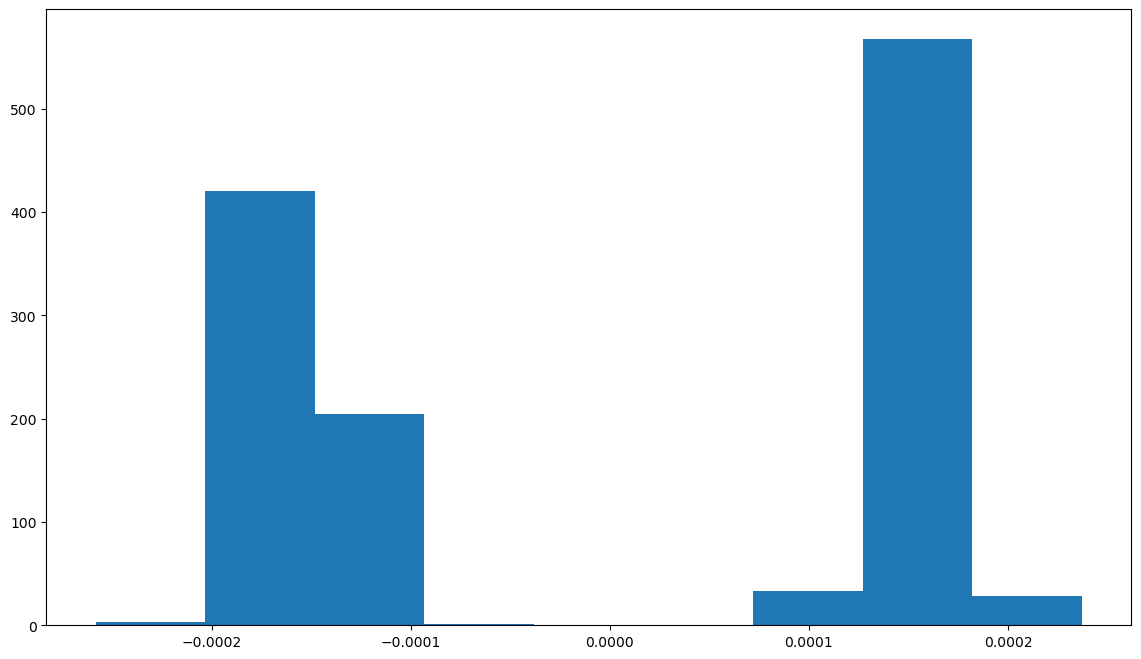

In [182]:
# IMFs input data (vmd param search)
modes, _, _ = vmd_lstm.vmd(y, n_modes=29, alpha=50)

In [183]:
# Split data(manually) and generate sequence slicing
x_train, y_train = modes[:-100], y[:-100]
x_test, y_test = modes[-100:], y[:-100]
data_gen = vmd_lstm.train_data(x_train, y_train)
data_gen_test = vmd_lstm.test_data(x_test)

Epoch 1/800
9/9 [==============================] - 6s 62ms/step - loss: 1.9139e-04
Epoch 2/800
9/9 [==============================] - 1s 61ms/step - loss: 1.9209e-04
Epoch 3/800
9/9 [==============================] - 1s 61ms/step - loss: 1.9123e-04
Epoch 4/800
9/9 [==============================] - 1s 70ms/step - loss: 1.9135e-04
Epoch 5/800
9/9 [==============================] - 1s 73ms/step - loss: 1.9113e-04
Epoch 6/800
9/9 [==============================] - 1s 81ms/step - loss: 1.9119e-04
Epoch 7/800
9/9 [==============================] - 1s 61ms/step - loss: 1.9109e-04
Epoch 8/800
9/9 [==============================] - 1s 80ms/step - loss: 1.9109e-04
Epoch 9/800
9/9 [==============================] - 1s 81ms/step - loss: 1.9104e-04
Epoch 10/800
9/9 [==============================] - 1s 64ms/step - loss: 1.9103e-04
Epoch 11/800
9/9 [==============================] - 1s 102ms/step - loss: 1.9101e-04
Epoch 12/800
9/9 [==============================] - 1s 71ms/step - loss: 1.9099e-04


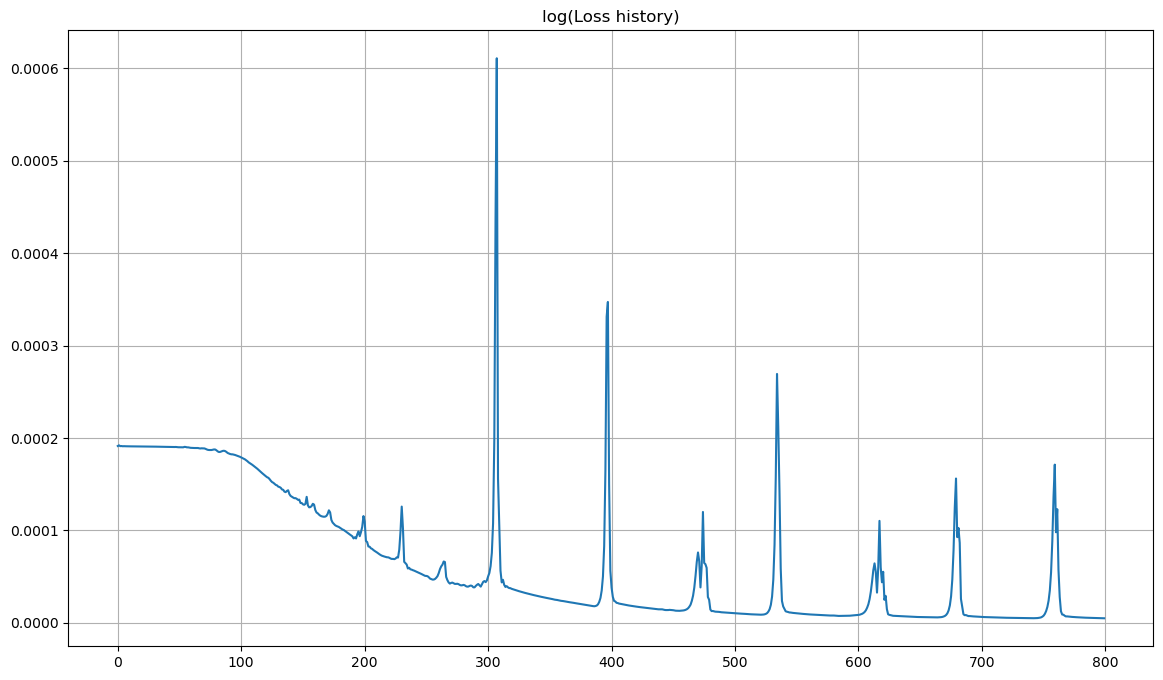

In [184]:
# Train
model = vmd_lstm.lstm(data_gen, epochs=800, learning_rate=1e-4)

### Performance test

In [187]:
def metrics(y_pred, y_act):
    '''Performance metrics.
    '''
    rmse = np.sqrt(1/len(y_act) * np.sum(np.square(y_act-y_pred)))
    mape = np.mean(np.abs(y_pred/y_act-1))
    wape = np.abs(np.sum(y_pred) / np.sum(y_act) -1)
    print("RMSE", round(rmse, 5))
    print("MAPE", round(mape, 5))
    print("WAPE", round(wape, 5))

9/9 [==============================] - 1s 62ms/step
RMSE 0.00219
MAPE inf
WAPE 0.91253


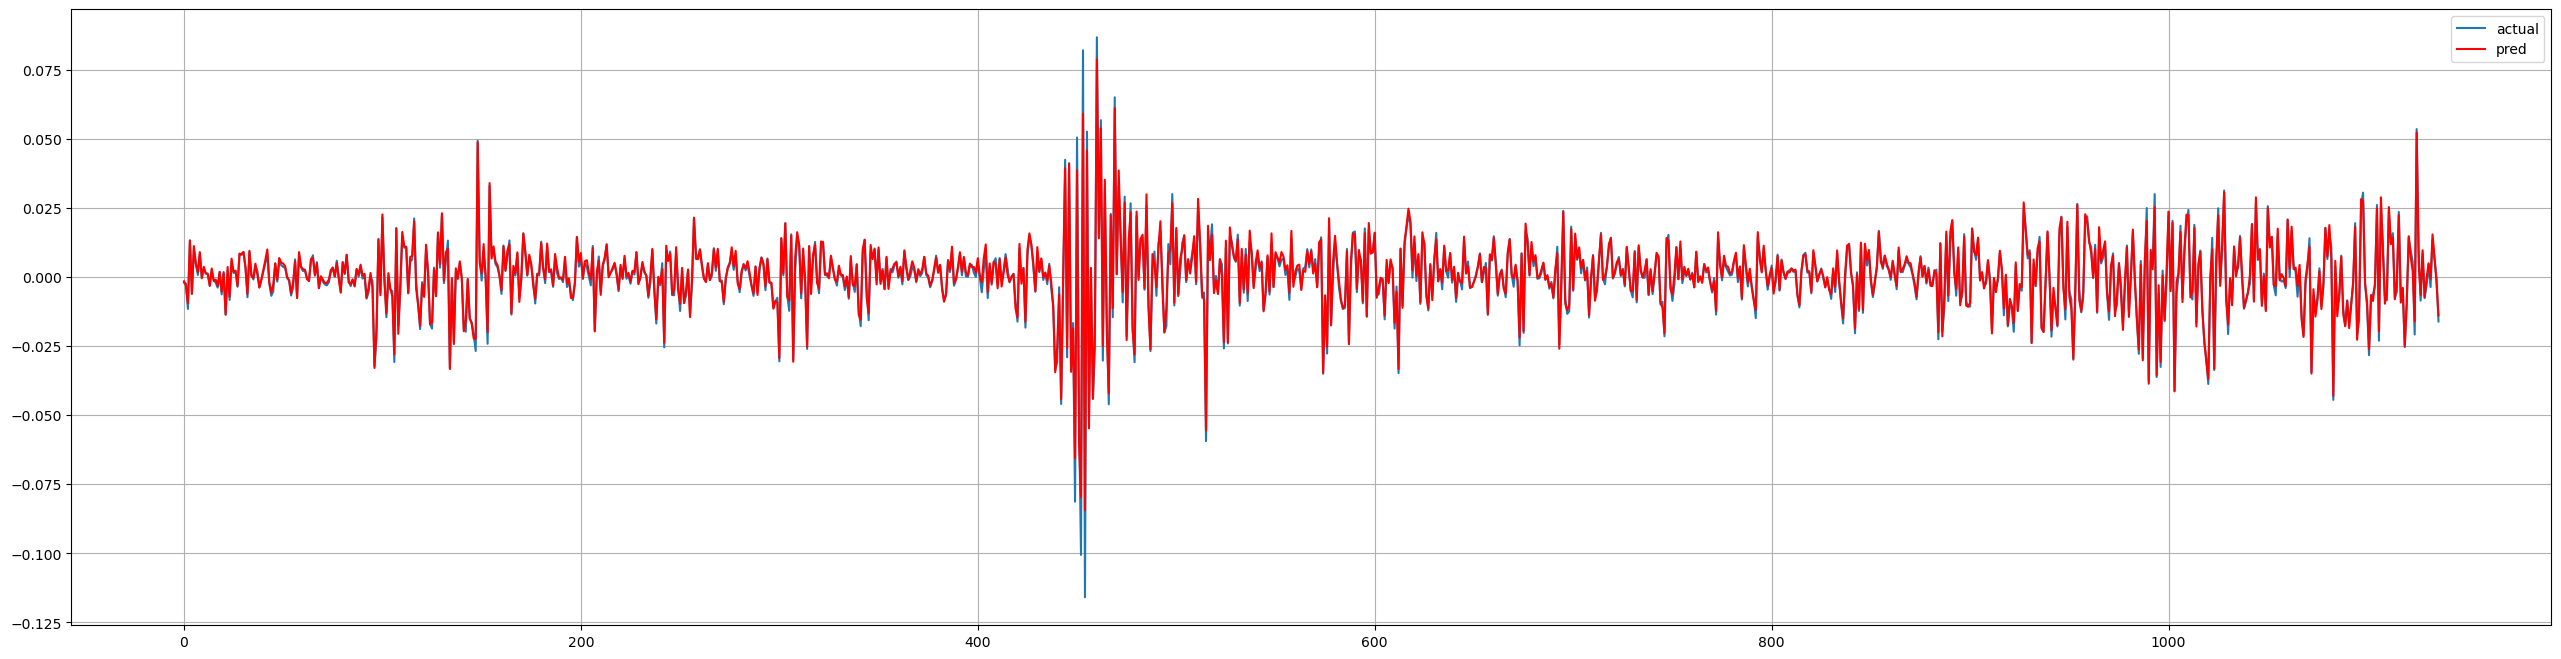

In [188]:
# Performance on seen data 15/250
y_pred, y_act = vmd_lstm.predict_train(data_gen)  # rmse calc not working as print into the func
metrics(np.expm1(y_pred), np.expm1(y_act))

1/1 [==============================] - 0s 94ms/step
RMSE 0.00154
MAPE 0.45189
WAPE 0.41213


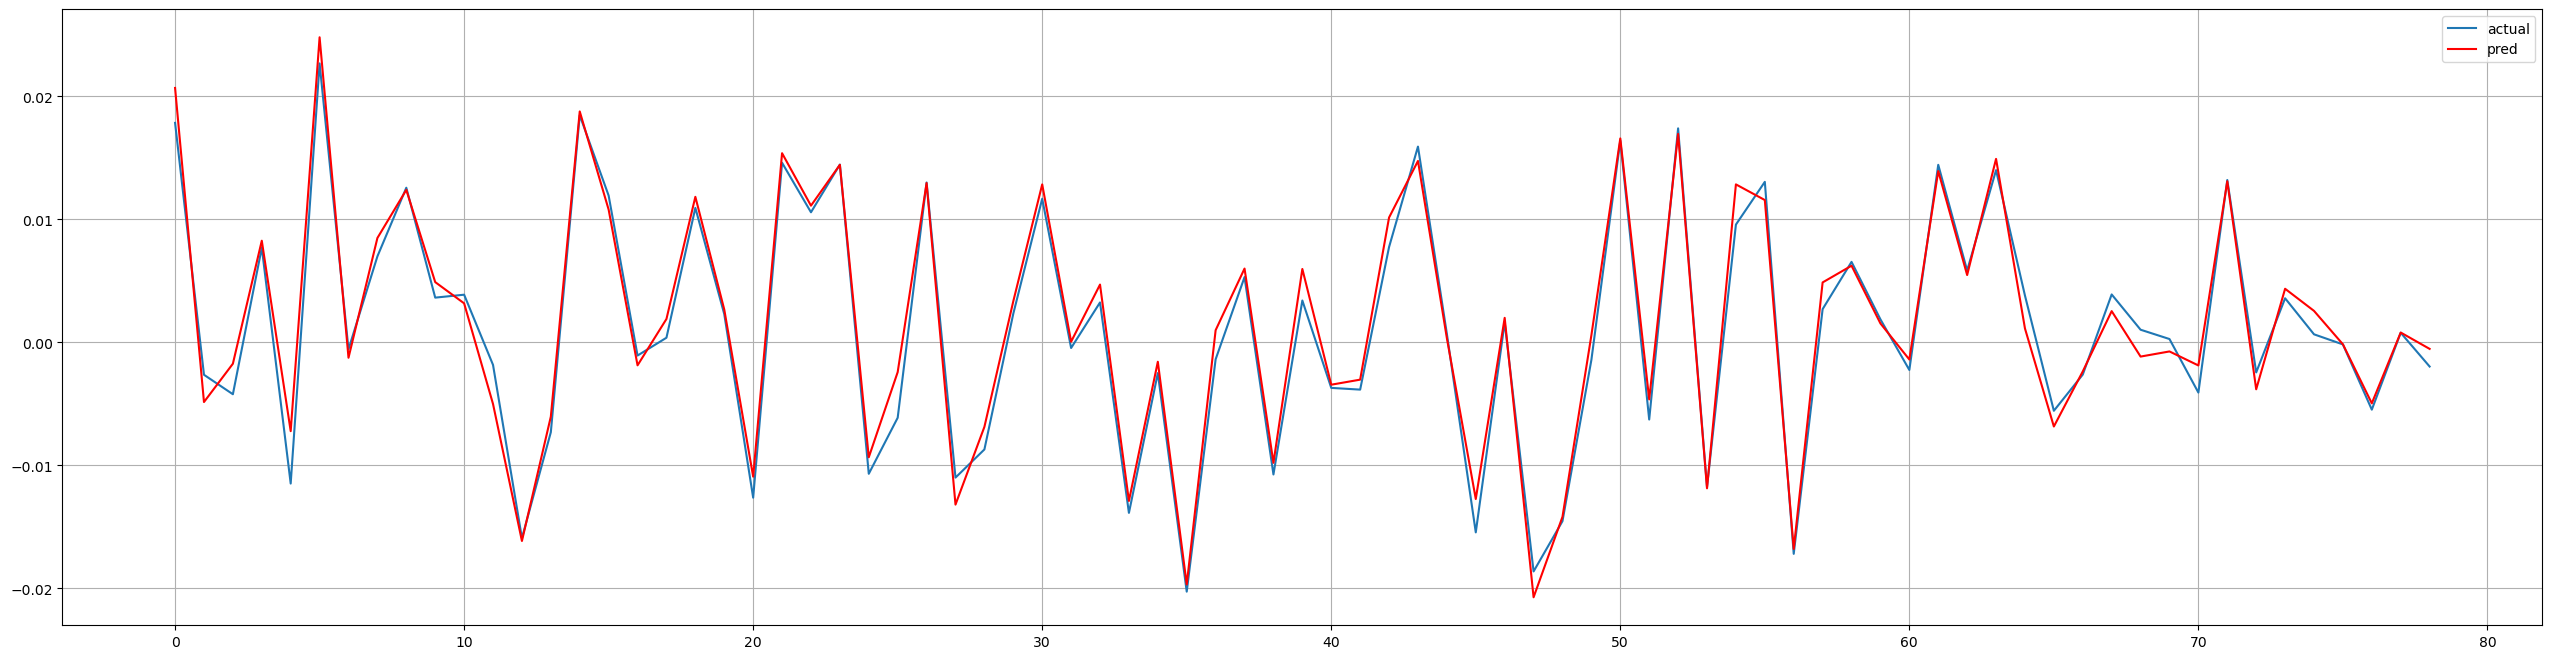

In [189]:
# Performance on unseen data 15/250
y_pred, y_act = vmd_lstm.predict_test(data_gen_test)  # rmse calc not working as print into the func
metrics(np.expm1(y_pred), np.expm1(y_act))

1/1 [==============================] - 0s 81ms/step
Next day return expected: -0.00071251334


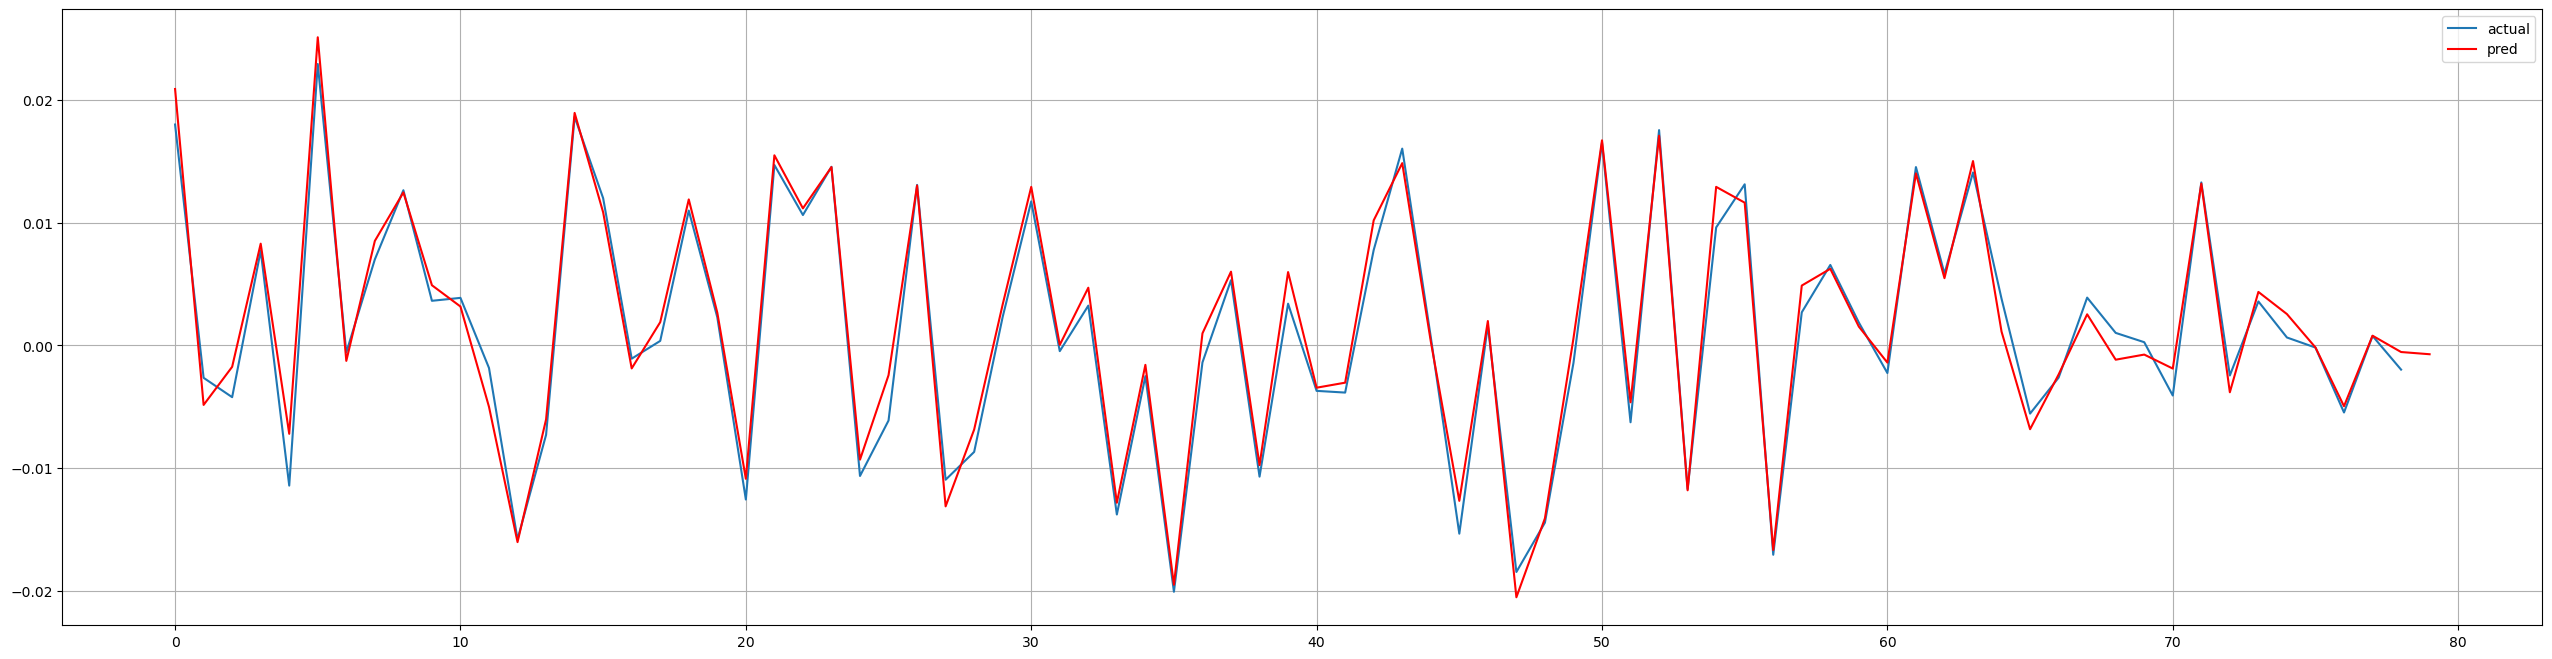

In [294]:
# add to np.zeros one more zero
# add to x_test last row of zeros or whatever in order to get the last row data for t+1 forecast
day_ahead_feat = np.concatenate([x_test, [np.zeros(29)]])
day_ahead_feat.shape
day_ahead_target = np.zeros(len(day_ahead_feat))

# Predict next day percentage change
last_batch = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            day_ahead_feat,
            day_ahead_target,
            length=21,
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=128
        ) 

offset_length = 100 - 21
y_act = pd.Series(y[-offset_length:])  # uses global y
day_ahead_pred = model.predict(last_batch)
day_ahead_pred = pd.Series(day_ahead_pred.T[0])
plt.figure(figsize=(32,8))
plt.plot(np.expm1(y_act), label='actual')
plt.plot(np.expm1(day_ahead_pred), c='r', label='pred')
plt.legend()
plt.grid()
print("Next day return expected:", y_pred.iloc[-1])

### VMD parameter search

In [47]:
%%time
# Sensitivity analysis
alphas = list(range(50, 525, 25))  #list(range(50, 100, 10))
Ks = list(range(2, 50, 1))  #list(range(2, 50, 1))
print('All combinations:', len(alphas) * len(Ks))

result_collect = []
for i in alphas:
    for j in Ks:
        modes, rmse, mape = vmd_lstm.vmd(y, n_modes=j, alpha=i, plot=False)
        result_collect.append([i, j, rmse, mape])
        
result = pd.DataFrame(result_collect, columns=['alpha', 'K', 'rmse', 'mape'])

All combinations: 912
CPU times: total: 15min 23s
Wall time: 17min 19s


First search

In [28]:
result.min()[2:]

rmse    0.395716
mse     0.020645
dtype: float64

In [36]:
result.nsmallest(5, ['rmse'])

,alpha,K,rmse,mse
44,50,46,0.395716,0.020782
40,50,42,0.395718,0.020785
45,50,47,0.395732,0.020784
30,50,32,0.395743,0.020781
46,50,48,0.395749,0.020790


In [37]:
result.nsmallest(5, ['mse'])

,alpha,K,rmse,mse
479,500,49,0.437731,0.020645
427,450,45,0.433354,0.020651
110,150,16,0.423473,0.020654
527,550,49,0.445059,0.020687
377,400,43,0.422108,0.020688


Sensitivity analysis:
- It seems that the most optimal K are around 45-50 for both RMSE and MAPE.
- With decreasing alpha we decrease RMSE and keep MAPE at low levels.
- Best pick will be low alpha and high decompose mode count.

Second search

In [6]:
result.min()[2:]

rmse    0.395677
mse     0.020641
dtype: float64

In [7]:
result.nsmallest(5, ['rmse'])  # alpha penalizer should be kept high with many modes (overfitting)

,alpha,K,rmse,mse
42,25,40,0.395677,0.020784
124,65,90,0.395688,0.020784
65,35,65,0.395688,0.020784
64,35,60,0.395688,0.020784
123,65,85,0.395688,0.020784


In [8]:
result.nsmallest(5, ['mse'])  # high alpha and low modes count should lead to bias

,alpha,K,rmse,mse
199,115,15,0.416654,0.020641
181,105,15,0.412467,0.020670
163,95,15,0.408625,0.020711
109,65,15,0.400503,0.020729
145,85,15,0.405880,0.020735


Third search

In [48]:
result.min()[2:]

rmse    0.395716
mape    0.020645
dtype: float64

In [52]:
result.nsmallest(5, ['mape'])

,alpha,K,rmse,mape
911,500,49,0.437731,0.020645
254,175,16,0.433502,0.020649
861,475,47,0.435196,0.020650
811,450,45,0.433354,0.020651
206,150,16,0.423473,0.020654


To do:
- Create standard procedure for choosing the best combination bias-variance wise. 
(Idea: first component should be close to moving average trend of the TS, rule of tumb: High IMFs count needs high alpha and vice versa)